In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.cluster.hierarchy import cophenet, fcluster
from nilearn import plotting, connectome, datasets, image
from nilearn.input_data import NiftiLabelsMasker
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
import matplotlib
from scipy import stats

In [2]:
plt.rcParams['figure.figsize'] = [7.4,3.7]

In [3]:
data_dir = '/media/synapse/bmacintosh_lab/nluciw/data/'

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rcParams.update({'font.size': 9})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
from matplotlib.legend_handler import HandlerTuple

### Results: Organization of CBF covariance in the HC group

The code here can be adapted to plot covariances from the BD group, and the Shen atlas reproduction.

In [5]:
# Get CBF and GM covariance
perf_correlations = np.load('cbf-covariance_aal-atlas.npy')
struc_correlations = np.load('gm-covariance_aal-atlas.npy')

In [6]:
# Prep covariance maps for plotting, with BD in upper and HC in lower triangles
perf_cors = np.triu(perf_correlations[0], k=1) + np.tril(perf_correlations[1], k=-1)
struc_cors = np.triu(struc_correlations[0], k=1) + np.tril(struc_correlations[1], k=-1)

In [7]:
# Compute hierarchical clustering of HC CBF covariance
z = linkage(perf_correlations[1], 'ward')
struc_linkage = linkage(struc_correlations[1], 'ward')

In [8]:
# get cophenetic correlation
c, coph_dists = cophenet(z, pdist(perf_correlations[1]))
c

0.7223429066739504

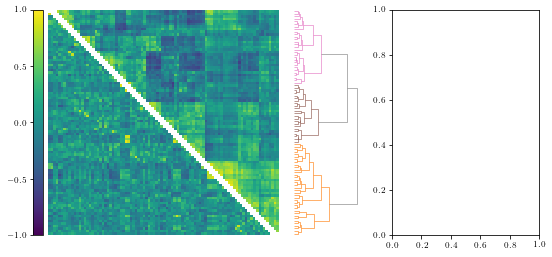

In [9]:
''' Make Figure 1 of paper. This cell creates Fig 1a and 1b, however 1b is upside-down; needs
    to be flipped to reproduce Figure 1. The atlas images for Fig 1c are created later in this
    notebook and the full Figure 1 was stitched together in Inkscape.
'''
fig = plt.figure(figsize=(7.1,3.55))

# Plot the dendrogram.
ax1 = fig.add_axes([0.57, 0.05, 0.13, 0.88])
set_link_color_palette(['C1', 'C5', 'C6', 'C3'])
matplotlib.rcParams['lines.linewidth'] = 0.6
dn = dendrogram(z, ax = ax1, color_threshold = 12, above_threshold_color='grey', orientation='right')
ax1.set_xticklabels(['']*88)
ax1.set_yticklabels([])
ax1.set_yticks([])
ax1.axis('off')

# Organize CBF and GM covariance according to dendrogram. 
idx = dn['ivl']
hc_cors = np.take(perf_correlations[1], indices=idx, axis=0)
hc_cors = np.take(hc_cors, indices=idx, axis=1)
hc_struccors = np.take(struc_correlations[1], indices=idx, axis=0)
hc_struccors = np.take(hc_struccors, indices=idx, axis=1)

# Plot CBF covariance map.
ax2 = fig.add_axes([0.10, 0.05, 0.44, 0.88])
mask = np.tril(np.ones((88,88)),k=0)
masked_hc_cors = np.ma.masked_array(hc_cors, mask)
mat_im = ax2.imshow(masked_hc_cors, cmap='viridis', vmin=-1., vmax=1., interpolation='nearest')
ax2.set_xticks([])
ax2.set_yticks([])
bottom, top = ax2.get_ylim()
ax2.axis('off')
ax2.tick_params(labelsize=6)

# Plot GM covariance map.
ax3 = fig.add_axes([0.09, 0.05, 0.44, 0.88])
#mat_im = ax2.imshow(np.triu(hc_cors, k=1) + np.tril(hc_struccors, k=-1), cmap='viridis', vmin=-1., vmax=1., interpolation='nearest')
mask = np.triu(np.ones((88,88)),k=0)
masked_hc_struccors = np.ma.masked_array(hc_struccors, mask)
mat_im = ax3.imshow(masked_hc_struccors, cmap='viridis', vmin=-1., vmax=1., interpolation='nearest')
ax3.set_xticks([])
ax3.set_yticks([])
#ax2.set_ylim([90,0])
#ax2.set_xlim([0,90])
ax3.axis('off')
ax3.tick_params(labelsize=6)

# Plot colourbar.
fig.add_axes([.762, 0.05, 0.288, .88])
cax = plt.axes([0.06, 0.05, 0.02, 0.88])
fig.colorbar(mat_im, cax=cax, ticks=[-1.,-0.5, 0., 0.5, 1.], spacing='uniform', pad=0.038)
cax.yaxis.set_ticks_position('left')
#fig.savefig('AAL_BD_matrix_w-dendrogram.svg', format='svg', dpi=500)

In [10]:
# Load the AAL atlas.
aal = image.load_img('AAL-atlas_overlap-w-ASL.nii.gz')
aal_data = aal.get_data()
aal_masker = NiftiLabelsMasker(labels_img = aal,
                               mask_img = None,
                              standardize = False)
aal_masker.fit()

# Get all the AAL regions.
aal_regions = aal_masker.transform(
    [aal,aal])[0]

/Users/nicholas/environments/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Get the cluster membership labels for each region.
memberships = fcluster(z, t=12, criterion='distance')

In [12]:
# Get the number of regions in each cluster.
num1 = np.sum(memberships==1)
num2 = np.sum(memberships==2)
num3 = np.sum(memberships==3)

In [13]:
# Pick inter- and intra- cluster covariance values
cl1 = hc_cors[:num1,:num1]
cl1_wcl2 = hc_cors[:num1,num1:num1+num2]
cl1_wcl3 = hc_cors[:num1,num1+num2:]
cl2 = hc_cors[num1:num1+num2,num1:num1+num2]
cl2_wcl3 = hc_cors[num1:num1+num2,num1+num2:]
cl3 = hc_cors[num1+num2:,num1+num2:]

In [14]:
# Get the average inter- and intra- cluster CBF covariance:
avg_c1 = (connectome.sym_matrix_to_vec(cl1, discard_diagonal=True)).mean()
avg_c2 = (connectome.sym_matrix_to_vec(cl2, discard_diagonal=True)).mean()
avg_c3 = (connectome.sym_matrix_to_vec(cl3, discard_diagonal=True)).mean()
avg_c1, avg_c2, avg_c3
avg_c1wc2 = (connectome.sym_matrix_to_vec(cl1_wcl2, discard_diagonal=True)).mean()
avg_c1wc3 = (connectome.sym_matrix_to_vec(cl1_wcl3, discard_diagonal=True)).mean()
avg_c2wc3 = (connectome.sym_matrix_to_vec(cl2_wcl3, discard_diagonal=True)).mean()
avg_c1, avg_c2, avg_c3, avg_c1wc2, avg_c1wc3, avg_c2wc3

(0.1047332744131622,
 0.29779336513420607,
 0.4463215720063555,
 -0.14994692188753325,
 -0.05394111831171367,
 -0.021052366999092083)

In [15]:
# Create the arrays for each cluster image.
aal_clust1 = np.zeros_like(aal_data)
aal_clust2 = np.zeros_like(aal_data)
aal_clust3= np.zeros_like(aal_data)

# Populate the arrays with the regions within each cluster.
for i in range(num1):
    region = aal_regions[np.int(idx[i])]
    aal_clust1[np.equal(aal_data, region)] = region
for i in range(num1,num1+num2):
    region = aal_regions[np.int(idx[i])]
    aal_clust2[np.equal(aal_data, region)] = region
for i in range(num1+num2,num1+num2+num3):
    region = aal_regions[np.int(idx[i])]
    aal_clust3[np.equal(aal_data, region)] = region
#for i in range(num1+num2+num3, num1+num2+num3+num4):
#    region = aal_regions[np.int(idx[i])]
#    aal_clust4[np.equal(aal_data, region)] = region

In [16]:
# Create nilearn Nifti objects from cluster arrays. To make plotting easier.
clust1 = image.new_img_like(ref_niimg=aal, data=aal_clust1)
clust2 = image.new_img_like(ref_niimg=aal, data=aal_clust2)
clust3 = image.new_img_like(ref_niimg=aal, data=aal_clust3)
#clust4 = image.new_img_like(ref_niimg=aal, data=aal_clust4)

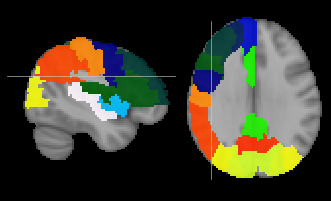

In [17]:
# Plot cluster 1.
plotting.plot_roi(clust1, black_bg=True, display_mode='xz', annotate=False, cut_coords=[-44,30], alpha=0.9)

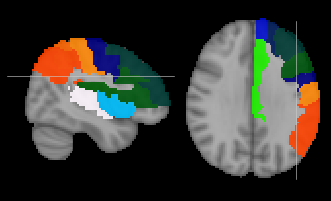

In [18]:
# Plot cluster 2.
plotting.plot_roi(clust2, black_bg=True, display_mode='xz', annotate=False, cut_coords=[44,30], alpha=0.9)

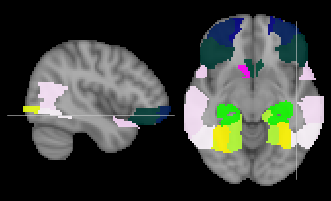

In [19]:
# Plot cluster 3.
plotting.plot_roi(clust3, black_bg=True, display_mode='xz', annotate=False, cut_coords=[44,-10], alpha=0.9)

### Results: CBF-structure correspondence in the HC and BD groups

In [20]:
# Get only upper half of both for similarity between covariances
perf_hc = connectome.sym_matrix_to_vec(perf_correlations[1], discard_diagonal=True)
perf_bd = connectome.sym_matrix_to_vec(perf_correlations[0], discard_diagonal=True)

struc_hc = connectome.sym_matrix_to_vec(struc_correlations[1], discard_diagonal=True)
struc_bd = connectome.sym_matrix_to_vec(struc_correlations[0], discard_diagonal=True)

# Load into dataframe for convenience
correlations_df = pd.DataFrame({'perf_hc': perf_hc, 'perf_bd':perf_bd, 'struc_hc':struc_hc, 'struc_bd':struc_bd})

In [21]:
coupling_hc = round(np.corrcoef(np.array(struc_hc), np.array(perf_hc))[0][1], 2)
coupling_bd = round(np.corrcoef(np.array(struc_bd), np.array(perf_bd))[0][1], 2)
print('Correlation between covariances in HC group:', coupling_hc,
      '\nCorrelation between covariances in BD group:', coupling_bd)

Correlation between covariances in HC group: 0.2 
Correlation between covariances in BD group: 0.36


In [22]:
''' Permutation test for p-vals of above correlations. Look for correlations in the 
    *absence of true relationship between perfusion and structure*. That is, correlate 
    the flattened perfusion map against a randomly permuted flattened structure map.
'''
def get_perm_corrs(perf, struc, num_iters):
    corrs = []
    np.random.seed(123)
    for iterate in range(num_iters):
        perm = np.random.permutation(struc.shape[0])
        permed_struc = struc[perm]
        permed_struc = permed_struc[:,perm] 
        perm = np.random.permutation(perf.shape[0])
        #perf = perf[perm,:]
        #perf = perf[:,perm] 
        flat_perf = connectome.sym_matrix_to_vec(perf,discard_diagonal=True)
        flat_struc = connectome.sym_matrix_to_vec(permed_struc, discard_diagonal=True)
        corrs.append(np.corrcoef(flat_perf, flat_struc)[1,0])
    return corrs
        
perf_hc = correlations_df['perf_hc']
struc_hc = correlations_df['struc_hc']
perf_bd = correlations_df['perf_bd']
struc_bd = correlations_df['struc_bd']

In [23]:
permed_corrs_hc = get_perm_corrs(perf_correlations[1], struc_correlations[1], 10000)
permed_corrs_bd = get_perm_corrs(perf_correlations[0], struc_correlations[0], 10000)

In [27]:
print('p-val of CBF-structure correspondence in HC group:', np.sum(abs(np.array(permed_corrs_hc)) >= coupling_hc)/10000,
      '\np-val of CBF-structure correspondence in BD group:', np.sum(abs(np.array(permed_corrs_bd)) >= coupling_bd)/10000) 

p-val of CBF-structure correspondence in HC group: 0.0 
p-val of CBF-structure correspondence in BD group: 0.0


The above p-vals (0.0) actually indicate p<0.0001

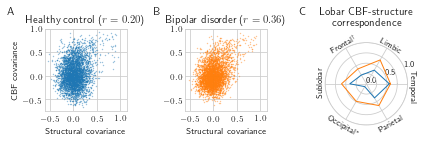

In [31]:
''' Plot Figure 2 from paper.'''
sns.set_style('whitegrid')
fig = plt.figure(figsize=(6.5,2.4))
ax = plt.subplot(131), plt.subplot(132), plt.subplot(133, projection='polar')

# Plot perfusion covariance against structural covariance for HC
hc_plot = sns.scatterplot('struc_hc', 'perf_hc', data=correlations_df, s=2,alpha=0.45, color='C0', ax=ax[0], linewidth=0.)
hc_plot.set(xlabel='Structural covariance', ylabel='CBF covariance')
ax[0].set_xlim(-0.6,1.15), ax[0].set_ylim(-0.75,1.)
ax[0].set_yticks([-0.5, 0., 0.5, 1.])
ax[0].set_xticks([-0.5, 0., 0.5, 1.])
ax[0].set_title(r'Healthy control ($r=0.20$)')
ax[0].set(adjustable='box', aspect='equal')

# Only show ticks on the left and bottom spines
ax[0].tick_params(axis=u'both', which=u'both',length=0)

# Plot correspondence for BD
bd_plot = sns.scatterplot('struc_bd', 'perf_bd', data=correlations_df, s=2,alpha=0.45, color='C1', ax=ax[1], linewidth=0.)
bd_plot.set(xlabel='Structural covariance', ylabel='')
ax[1].set_xlim(-0.6,1.15), ax[1].set_ylim(-0.75,1.)
ax[1].set_yticks([-0.5, 0., 0.5, 1.])
ax[1].set_xticks([-0.5, 0., 0.5, 1.])
ax[1].set_title(r'Bipolar disorder ($r=0.36$)')
ax[1].set(adjustable='box', aspect='equal')

# Only show ticks on the left and bottom spines
ax[1].tick_params(axis=u'both', which=u'both',length=0)
plt.subplots_adjust(wspace=0.7)

# Get lobar correspondence, analysis of which was done in separate code
df = pd.read_csv('lobar_correspondence2.csv')

theta = np.linspace(0, 2 * np.pi, 7)

lines, labels = plt.thetagrids(range(0,360, int(360/6)), 
                               (['Temporal', 'Limbic', r'Frontal$^\dag$', 'Sublobar', r'Occipital$^*$', 'Parietal']))
ax[2].plot(theta, list(df[df.Dx=='HC'].Correspondence) + [0.557578], color='C0', lw=1)

ax[2].plot(theta, list(df[df.Dx=='BD'].Correspondence) + [0.584865], ls='-', color='C1', lw=1)
ax[2].set_ylim(0,1)
ax[2].set_yticks([0,0.25,0.50,0.75,1.])
ax[2].set_yticklabels([0.0,'',0.5,'',1.], fontsize=8)
ax[2].set_xticklabels([])

# Required a lot of tweaking of labels to get everything to look good
ax[0].text(-1.4,1.3, 'A', weight=1000, fontsize=11)
ax[1].text(-1.25,1.3, 'B', fontweight='bold', fontsize=11)
ax[2].text(2.34,2.35, 'C', fontweight='bold', fontsize=11)
ax[2].text(2.45,1.17, r'Frontal$^\dag$', rotation=30, fontsize=8)
ax[2].text(1.22,0.81, 'Limbic', rotation=-30, fontsize=8)
ax[2].text(-0.41,1.12, 'Temporal', rotation=-90, fontsize=8)
ax[2].text(-1.35,1.21, 'Parietal', rotation=30, fontsize=8)
ax[2].text(-2.23,1.61, r'Occipital$^*$', rotation=-30, fontsize=8)
ax[2].text(-2.88,1.25, 'Sublobar', rotation=90, fontsize=8)

ax[2].set_title('Lobar CBF-structure\ncorrespondence')
box = ax[2].get_position()
box.y0 = box.y0 - 0.08
box.y1 = box.y1 - 0.08
ax[2].set_position(box)
ttl = ax[2].title
ttl.set_position([0.5,1.14])

legend_elements = [Line2D([0], [0], ls='-', color='black', label='HC'),
                   Line2D([0], [0], ls='--', color='black', label='BD')]

#plt.savefig('../figures/Figure3.png', dpi=800)

#### In the following few cells, we get the permutation-based p value for the group difference in CBF-GM coupling.
This requires individual-level data, which we cannot provide.

In [36]:
# Load the regional CBF and GM values
hc_perf_values = np.load('regional-cbf_aal-atlas_hc.npy')
hc_struc_values = np.load('regional-gm_aal-atlas_hc.npy')

bd_perf_values = np.load('regional-cbf_aal-atlas_bd.npy')
bd_struc_values = np.load('regional-gm_aal-atlas_bd.npy')

perfs = np.concatenate((hc_perf_values, bd_perf_values), axis=0)
strucs = np.concatenate((hc_struc_values, bd_struc_values), axis=0)

def get_corr_diffs(perf, struc, iters):
    """Randomly permute group labels, re-calculate covariance maps, and generate difference between
     groups' CBF-structure correspondence. Returns null distribution of differences."""

    full_diffs = []
    np.random.seed(123)
    for iteration in range(iters):
        idx = np.random.permutation(perf.shape[0])
        hc_perf, bd_perf = perf[idx[:56],:], perf[idx[56:],:]
        hc_struc, bd_struc = struc[idx[:56],:], struc[idx[56:],:]
        hc_pcov = connectome.sym_matrix_to_vec(np.corrcoef(hc_perf.T), discard_diagonal=True)

        bd_pcov = connectome.sym_matrix_to_vec(np.corrcoef(bd_perf.T), discard_diagonal=True)
        hc_scov = connectome.sym_matrix_to_vec(np.corrcoef(hc_struc.T), discard_diagonal=True)
        bd_scov = connectome.sym_matrix_to_vec(np.corrcoef(bd_struc.T), discard_diagonal=True)
        
        hc_corr = np.corrcoef(hc_pcov, hc_scov)[1,0]
        bd_corr = np.corrcoef(bd_pcov, bd_scov)[1,0]
        
        full_diffs.append(bd_corr-hc_corr)

    return full_diffs

In [33]:
null_diffs = get_corr_diffs(perfs, strucs, 10000)

In [34]:
true_diff = coupling_bd - coupling_hc
p = np.sum(np.abs(null_diffs) >= true_diff) / 10000

In [35]:
print('Difference in CBF-GM coupling between groups is {0} (p={1})'.format(round(true_diff,2),p))

Difference in CBF-GM coupling between groups is 0.16 (p=0.0028)


### Results: Group by covariance interactions separately for CBF and structure
This also requires individual-level data, which we cannot provide.

In [23]:
# Use FDR control for multiple comparisons correction
def get_fdr_threshold(p_vals, alpha, n_comparisons):

        p_sorted = (np.sort(p_vals.flatten()))
        k = [ii*alpha/n_comparisons for ii in range(1, n_comparisons+1)]

        below = p_sorted < k
        if np.sum(below) > 0:
            max_below = np.max(np.where(below)[0])
        else:
            max_below = 0

        return k[max_below]

In [24]:
perf_diff = connectome.sym_matrix_to_vec(perf_correlations[2], discard_diagonal=True)
struc_diff = connectome.sym_matrix_to_vec(struc_correlations[2], discard_diagonal=True)

perf_p = stats.norm.sf(abs(perf_diff))*2.
struc_p = stats.norm.sf(abs(struc_diff))*2.

In [25]:
# Do CBF covariance test for group differences
cbf_thresh = get_fdr_threshold(perf_p, alpha=0.05, n_comparisons=perf_p.shape[0])

In [26]:
# Do GM covariance test for group differences
gm_thresh = get_fdr_threshold(struc_p, alpha=0.05, n_comparisons=struc_p.shape[0])

In [33]:
z_thresh = abs(stats.norm.ppf(cbf_thresh/2))

In [34]:
coords, labels = plotting.find_parcellation_cut_coords(labels_img='AAL-atlas_overlap-w-ASL.nii.gz', return_label_names=True)
idx = np.argsort(labels)
labels_sorted = [labels[i] for i in idx]

AAL = datasets.fetch_atlas_aal()
aal_idxs = AAL.labels
regionsA = np.where(perf_correlations[2] < -z_thresh)[0]
regionsB = np.where(perf_correlations[2] < -z_thresh)[1]
region_names = [aal_idxs[i] for i in tuple(regionsA)]

In [35]:
tri_idx = np.triu_indices(88, k=1)

In [38]:
print('Relative to HC, in BD there is significantly lower CBF covariance between the {0} and the {1} (z={2}) and between the {3} and the {4} (z={5}).'.format(
    region_names[0],region_names[2], round(perf_correlations[2][regionsA[0],regionsB[0]],2),
    region_names[1], region_names[3], round(perf_correlations[2][regionsA[1],regionsB[1]],2)))

Relative to HC, in BD there is significantly lower CBF covariance between the Precentral_L and the Angular_L (z=-4.28) and between the Postcentral_L and the Angular_L (z=-4.93).


In [41]:
df = pd.DataFrame({'pre_L': perfs[:,0], 'post_L': perfs[:,56], 'ang': perfs[:,64]})

In [42]:
df['Dx'] = ['HC',]*56+['BD',]*68

In [43]:
m = pd.read_csv('sga.txt', sep="\n", header=None)

In [44]:
df['m'] = [0,]*56+list(m[0])

In [45]:
pre_L_loc = np.zeros_like(aal_data)
pre_L_loc[np.equal(aal_data, 2001)] = 2001
pre_L_loc[np.equal(aal_data, 6221)] = 6221
pre_L_nib = image.new_img_like(data=pre_L_loc, ref_niimg=aal)

In [46]:
from matplotlib.colors import ListedColormap

In [47]:
post_L_loc = np.zeros_like(aal_data)
post_L_loc[np.equal(aal_data, 6001)] = 6001
post_L_loc[np.equal(aal_data, 6221)] = 6221
post_L_nib = image.new_img_like(data=post_L_loc, ref_niimg=aal)

In [48]:
from matplotlib.lines import Line2D
sns.set_style('whitegrid')

/Users/nicholas/environments/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


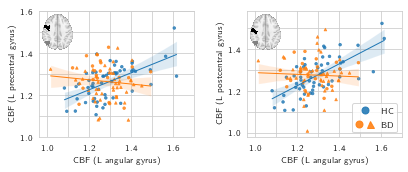

In [49]:
pt_size = 7
ln_size= 1

fig, ax = plt.subplots(1,2,figsize=(6.5,3.))
sns.regplot(x='ang', y='pre_L', data=df.loc[df.Dx=='HC'], ax=ax[0], color='C0', 
            scatter_kws={"s": 0},
            line_kws={'lw':ln_size})
sns.scatterplot(x='ang', y='pre_L', data = df.loc[df.Dx=='HC'], ax=ax[0], color='C0',
                style='m', s=pt_size, legend=None, markers=['o','^'], edgecolor='C0', alpha=0.8)
sns.regplot(x='ang', y='pre_L', data=df.loc[df.Dx=='BD'], ax=ax[0], color='C1', 
            scatter_kws={"s": 0},
            line_kws={'lw':ln_size, 'ls':'-'})
sns.scatterplot(x='ang', y='pre_L', data = df.loc[df.Dx=='BD'], ax=ax[0], color='C1',
                style='m', s=pt_size, legend=None, markers=['o','^'], edgecolor='C1', alpha=0.8)
ax[0].set(adjustable='box', aspect='equal')


sns.regplot(x='ang', y='post_L', data=df.loc[df.Dx=='HC'], ax=ax[1], color='C0', 
            scatter_kws={"s": 0},
            line_kws={'lw':ln_size})
sns.scatterplot(x='ang', y='post_L', data = df.loc[df.Dx=='HC'], ax=ax[1], color='C0',
                style='m', s=pt_size, legend=None, markers=['o','^'], edgecolor='C0', alpha=0.8)
sns.regplot(x='ang', y='post_L', data=df.loc[df.Dx=='BD'], ax=ax[1], color='C1', 
            scatter_kws={"s": 0},
            line_kws={'lw':ln_size, 'ls':'-'})
sns.scatterplot(x='ang', y='post_L', data = df.loc[df.Dx=='BD'], ax=ax[1], color='C1',
                style='m', s=pt_size, legend=None, markers=['o','^'], edgecolor='C1', alpha=0.8)
ax[1].set(adjustable='box', aspect='equal')

ax[0].set_xlim([0.96,1.7])
ax[0].set_ylim([1.0,1.6])
ax[0].set_xlabel('CBF (L angular gyrus)')
ax[0].set_ylabel('CBF (L precentral gyrus)')
ax[0].set_yticks([1.0,1.1,1.2,1.3,1.4,1.5,1.6])
ax[0].set_yticklabels(['1.0','', '1.2','','1.4','','1.6'])
ax[0].set_xticks([1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7])
ax[0].set_xticklabels(['1.0','', '1.2','','1.4','','1.6'])

ax[1].set_xlim([0.96,1.7])
ax[1].set_ylim([0.88,1.48])
ax[1].set_xlabel('CBF (L angular gyrus)')
ax[1].set_ylabel('CBF (L postcentral gyrus)')
ax[1].set_yticklabels(['','1.0','', '1.2','','1.4'])
ax[1].set_xticks([1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7])
ax[1].set_xticklabels(['1.0','', '1.2','','1.4','','1.6',''])

plt.subplots_adjust(wspace=0.34)

legend_elements = [Line2D([0], [0], marker='o', linestyle='',mec='C0', mfc='C0', label='HC',
                          markerfacecolor='black', markersize=7, alpha=0.88),
                   Line2D([0], [0], marker='o', linestyle='',color='C1', label='BD',
                          markerfacecolor='C1', mec='C1', markersize=7, alpha=0.88),
                   Line2D([0], [0], marker='^', linestyle='', color='C1', label='BD',
                          markerfacecolor='C1', mec='C1',markersize=7, alpha=0.88)]

#ax[1].legend(handles=legend_elements, loc='lower right')
ax[1].legend([legend_elements[0], (legend_elements[1],legend_elements[2])], ['HC','BD'], 
             handler_map={tuple:HandlerTuple(ndivide=None)},loc='lower right')

ax_pre = fig.add_axes([0.13,0.575,0.07,0.24])
plotting.plot_roi(pre_L_nib, display_mode='z', cut_coords = [38], 
                  annotate=False, black_bg=False, cmap=ListedColormap(['Black','Grey']),
                  axes=ax_pre, alpha=1.)

ax_post = fig.add_axes([0.574,0.575,0.07,0.24])
plotting.plot_roi(post_L_nib, display_mode='z', cut_coords = [38], 
                  annotate=False, black_bg=False, cmap=ListedColormap(['Black','Grey']),
                  axes=ax_post, alpha=1.)

#plt.savefig('../figures/Figure4.png', dpi=800, bbox_inches='tight')
